In [132]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, Model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [133]:
activation_functions = {
    'tanh': tf.tanh,
    'relu': tf.nn.relu,
    'sigmoid': tf.nn.sigmoid,
    'linear': tf.keras.activations.linear,
    'softmax': tf.nn.softmax,
}

**Loading Data**

In [134]:
%%time

# numpy
_, (X_test, y_test) = mnist.load_data() # only care  about X_test

X_test = X_test.reshape(10000, 784).astype(np.float32) / 255.0
y_test = to_categorical(y_test)  # one-hot encoding

# tensorflow
X_test = tf.convert_to_tensor(np.transpose(X_test))
y_test = tf.convert_to_tensor(np.transpose(y_test))

CPU times: total: 234 ms
Wall time: 230 ms


**Network Definition**

In [135]:
MUTATE_RATE_MATRIX = 0.3
MUTATE_RATE_BIAS = 0.1
MUTATE_RATE_ACTIVATION_FUNCTION = 0.1
GAUSSIAN_NOISE_STDDEV = 1

In [152]:
class MultiLayerPerceptron(Model):
    def __init__(self, **params):
        """
        Weight gnostic multi-layer feed forward neural network
        :param params: Params have to be in form: (matrix1=..., bias1=..., activation1=..., matrix2=..., ...)
        """
        super(MultiLayerPerceptron, self).__init__()

        self.n_layers = max([int(param_name[-1]) for param_name in params.keys()])   # = number of hidden layers + 1 (output layer)

        for (param_name, param) in params.items():
            assert param_name[:-1] in ('matrix', 'bias', 'activation'), 'Invalid attribute!'
            setattr(self, param_name, param)

    def call(self, inputs):
        x = inputs

        for layer in range(1, self.n_layers + 1):
            x = getattr(self, 'matrix' + str(layer)) @ x
            x += getattr(self, 'bias' + str(layer))
            x = activation_functions[getattr(self, 'activation' + str(layer))](x)

        return x

    # TODO: without custom function?
    def evaluate(self):
        y_pred = np.argmax(self.call(X_test), axis=0)
        y_true = np.argmax(y_test, axis=0)
        return np.mean(y_pred == y_true)

    def mutate(self):
        for layer in range(1, self.n_layers + 1):
            # matrix
            matrix = getattr(self, 'matrix' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_MATRIX, MUTATE_RATE_MATRIX]]),
                matrix.shape[0] * matrix.shape[1]), matrix.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=matrix.shape)
            matrix = matrix + tf.multiply(mutation_stencil, noise)
            setattr(self, 'matrix' + str(layer), matrix)

            # bias
            bias = getattr(self, 'bias' + str(layer))
            mutation_stencil = tf.cast(tf.reshape(tf.random.categorical(
                tf.math.log([[1 - MUTATE_RATE_BIAS, MUTATE_RATE_BIAS]]),
                bias.shape[0]), bias.shape), tf.float32)
            noise = tf.random.normal(mean=0.0, stddev=GAUSSIAN_NOISE_STDDEV, shape=bias.shape)
            bias = bias + tf.multiply(mutation_stencil, noise)
            setattr(self, 'bias' + str(layer), bias)

            # activation
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))
            if random.uniform(0, 1) < MUTATE_RATE_ACTIVATION_FUNCTION:
                activation = random.choice(list(activation_functions.keys()))
            setattr(self, 'activation' + str(layer), activation)

    def summary(self):
        dash = '-' * 75
        ddash = '=' * 75
        print(dash)
        print('Model')
        print(ddash)

        n_params = 0
        for layer in range(1, self.n_layers + 1):
            # get values
            matrix = getattr(self, 'matrix' + str(layer))
            bias = getattr(self, 'bias' + str(layer))
            cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
            activation = cleaner(getattr(self, 'activation' + str(layer)))

            n_params += matrix.shape[0] * matrix.shape[1] + bias.shape[0]

            # print adjustments
            activation = '({})'.format(activation)
            layer_IO = '(in={}, out={})'.format(matrix.shape[1], matrix.shape[0],)

            print('Linear {:<20}{:<30}#Params: {}'.format(activation, layer_IO, matrix.shape[0] * matrix.shape[1] + bias.shape[0]))

        print(ddash)
        print('Total params: {}'.format(n_params))
        print('Accuracy: {}'.format(self.evaluate()))

In [153]:
class Population:
    # TODO: n_layers evolvable
    def __init__(self, size=10, n_survivors=5, n_hidden_layers=1):
        """
        :param size: population size
        :param n_survivors: number of survivors after each generation (rest is killed and unable to pass on its genes)
        :param n_hidden_layers: number of hidden layers
        """
        self.generation = 0
        self.size = size
        self.n_survivors = n_survivors
        self.n_hidden_layers = n_hidden_layers
        self.elite = None
        self.fitness = None # cache fitness for increased speed
        self.fitness_generation = -1  # generation when fitness was evaluated

        # initialization (gaussian)
        # TODO: hidden layer width fixed for now
        self.organisms = []
        for _ in range(size):
            params = {}

            # first hidden layer
            params['matrix1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 784])
            params['bias1'] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 1])
            params['activation1'] = 'sigmoid'

            for hidden_layer in range(2, n_hidden_layers + 2):
                params['matrix' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 32])
                params['bias' + str(hidden_layer)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[32, 1])
                params['activation' + str(hidden_layer)] = 'sigmoid'

            # output layer
            params['matrix' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 32])
            params['bias' + str(self.n_hidden_layers + 1)] = tf.random.normal(mean=0.0, stddev=1.0, shape=[10, 1])
            params['activation' + str(self.n_hidden_layers + 1)] = 'softmax'

            model = MultiLayerPerceptron(**params)
            self.organisms.append(model)

        self.history = [(max(self.organism_fitness()), self.average_fitness())]   # fitness of population over all generations

    def organism_fitness(self):
        if self.generation != self.fitness_generation:
            self.fitness = [organism.evaluate() for organism in self.organisms]
            self.fitness_generation = self.generation

        return self.fitness

    def average_fitness(self):
        organism_fitness = self.organism_fitness()
        return sum(organism_fitness) / len(organism_fitness)

    def max_fitness(self):
        return max(self.organism_fitness())

    def selection(self):
        organism_fitness = self.organism_fitness()

        # elitism (n=1)
        elite_index = np.argmax(organism_fitness)
        self.elite = self.organisms.pop(elite_index)
        organism_fitness.pop(elite_index)

        probabilities = [fitness / sum(organism_fitness) for fitness in organism_fitness]  # normalized
        survivors = np.random.choice(self.organisms,
                                     size=self.n_survivors - 1,
                                     p=probabilities,
                                     replace=False)    # TODO: works without replacement and p?
        return [survivor for survivor in survivors]

    def crossover(self, parents):
        children = []
        while len(children) < (self.size - 1):
            [father, mother] = random.sample(parents + [self.elite], k=2)  # sample without replacement

            child_params = {}
            for layer in range(1, father.n_layers + 1):
                # matrix - uniform crossover
                father_matrix = getattr(father, 'matrix' + str(layer))
                mother_matrix = getattr(mother, 'matrix' + str(layer))

                father_stencil = tf.round(tf.random.uniform(father_matrix.shape))
                mother_stencil = - (father_stencil - 1)

                child_matrix = tf.multiply(father_stencil, father_matrix) + tf.multiply(mother_stencil, mother_matrix)
                child_params['matrix' + str(layer)] = child_matrix

                # bias - uniform crossover
                father_bias = getattr(father, 'bias' + str(layer))
                mother_bias = getattr(mother, 'bias' + str(layer))

                father_stencil = tf.round(tf.random.uniform(father_bias.shape))
                mother_stencil = - (father_stencil - 1)

                child_bias = tf.multiply(father_stencil, father_bias) + tf.multiply(mother_stencil, mother_bias)
                child_params['bias' + str(layer)] = child_bias

                # activation
                cleaner = lambda x: 'softmax' if x=='softmax_v2' else x
                father_activation = cleaner(getattr(father, 'activation' + str(layer)))
                mother_activation = cleaner(getattr(mother, 'activation' + str(layer)))

                child_activation = father_activation if (random.uniform(0, 1) < 0.5) else mother_activation
                child_params['activation' + str(layer)] = child_activation

            model = MultiLayerPerceptron(**child_params)
            children.append(model)

        return children

    def mutate(self, organisms):
        for organism in organisms:
            organism.mutate()

    def breed(self):
        #time_debug = ''

        #t_a = time.time()
        parents = self.selection()
        #t_b = time.time()
        #time_debug += 'selection time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        children = self.crossover(parents)
        #t_b = time.time()
        #time_debug += 'crossover time: {}s - '.format(round(t_b - t_a, 4))

        #t_a = time.time()
        self.mutate(children)  # TODO: mGA or GA?
        #t_b = time.time()
        #time_debug += 'mutation time: {}s - '.format(round(t_b - t_a, 4))

        #print(time_debug)

        self.organisms = children + [self.elite]
        self.generation += 1
        self.history.append((self.max_fitness(), self.average_fitness()))

    def plot(self):
        # plot evolution
        plt.figure()
        plt.plot(np.arange(self.generation + 1), [score[0] for score in self.history],
                 label='max fitness')
        plt.plot(np.arange(self.generation + 1), [score[1] for score in self.history],
                 label='avg fitness', alpha=0.6)
        plt.title('Population fitness' + ' (n=' + str(self.size) + ')')
        plt.xlabel('Generations')
        plt.ylabel('Fitness score (accuracy)')
        plt.legend()
        plt.show()

        # plot best performing final network
        organism_fitness = self.organism_fitness()
        elite_index = np.argmax(organism_fitness)
        self.organisms[elite_index].summary()

**Training**

In [156]:
# initialization
GENERATIONS = 400
POPULATION_SIZE = 30
SURVIVORS = 15
N_HIDDEN_LAYERS = 1

Starting training
Gen 0 : [0.1297, 0.0795, 0.1614, 0.0852, 0.1098, 0.1123, 0.0812, 0.0813, 0.117, 0.1257, 0.0929, 0.1136, 0.1446, 0.0638, 0.1071, 0.1148, 0.0994, 0.059, 0.0775, 0.0906, 0.0863, 0.1148, 0.1122, 0.1166, 0.0745, 0.1172, 0.1216, 0.1356, 0.0876, 0.1376] - max: 0.1614 (0.28s)
Gen 1 : [0.0841, 0.1342, 0.1145, 0.117, 0.1445, 0.1006, 0.0964, 0.1035, 0.1029, 0.1315, 0.0728, 0.0759, 0.1081, 0.1522, 0.1299, 0.0866, 0.0816, 0.1158, 0.1149, 0.1053, 0.0799, 0.1101, 0.1123, 0.1605, 0.1051, 0.0891, 0.062, 0.1099, 0.0806, 0.1614] - max: 0.1614 (0.4s)
Gen 2 : [0.0988, 0.0946, 0.0894, 0.0692, 0.1374, 0.1445, 0.0879, 0.1446, 0.0774, 0.1163, 0.1151, 0.1128, 0.1351, 0.0857, 0.111, 0.1372, 0.1251, 0.0811, 0.1562, 0.1106, 0.1464, 0.104, 0.1197, 0.0863, 0.0964, 0.0871, 0.0661, 0.1335, 0.1086, 0.1614] - max: 0.1614 (0.42s)
Gen 3 : [0.1481, 0.1247, 0.1043, 0.0993, 0.112, 0.1334, 0.1196, 0.1216, 0.0988, 0.1401, 0.0823, 0.1439, 0.0935, 0.0762, 0.0973, 0.0921, 0.094, 0.1137, 0.1357, 0.1169, 0.1137, 0

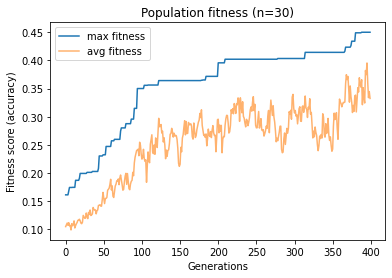

---------------------------------------------------------------------------
Model
Linear (linear)            (in=784, out=32)              #Params: 25120
Linear (relu)              (in=32, out=10)               #Params: 330
Total params: 25450
Accuracy: 0.45


In [157]:
# initial population
print('Starting training')
t_training = time.time()
population = Population(size=POPULATION_SIZE, n_survivors=SURVIVORS, n_hidden_layers=N_HIDDEN_LAYERS)
population_fitness = population.organism_fitness()
max_fitness = population.max_fitness()
t2 = time.time()
print('Gen', 0, ':',
      population_fitness, '- max:',
      max_fitness,
      '({}s)'.format(round(t2 - t_training, 2)))

# future populations
for generation in range(1, GENERATIONS):
    # breed new population
    t1 = time.time()
    population.breed()

    # evaluate new population
    population_fitness = population.organism_fitness()
    max_fitness = population.max_fitness()
    t2 = time.time()

    print('Gen', generation, ':',
          population_fitness, '- max:',
          max_fitness,
          '({}s)'.format(round(t2 - t1, 2)))

print('Finished training ({})'.format(round(time.time() - t_training, 2)))

# performance of population
population.plot()